In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

# Load dataset
file_path_new = r'C:\Users\Hubert N\Downloads\AMPICILLIN_E.COLI_12.4.24.csv'
df_new = pd.read_csv(file_path_new)

# Define target and features
columns_of_interest_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Age", "Weight (kg)", "Number of vet visits", "Hospitalization (no = 0; yes = 1)",
    "Duration of hospitalization (days)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Duration of therapy (days)", "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "USG", "PH", "Protein",
    "Glucose", "Ketones", "Creatinine", "Bilirubin...19", "Hemoprotein", "Sediment Vol",
    "Volume", "Lipid Layer", "WBC (simplified)", "Pyuria (1 if >/=4)", "RBC (simplified)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]

df_new = df_new[df_new["Ampicillin_RSI"].isin(["R", "S"])]
df_new['Ampicillin_RSI'] = df_new['Ampicillin_RSI'].map({'S': 0, 'R': 1})
target_new = df_new['Ampicillin_RSI']
features_new = df_new[columns_of_interest_new]

# Count and percentage of R vs. S cases
r_count = df_new['Ampicillin_RSI'].sum()  # Count of R cases
s_count = len(df_new) - r_count  # Count of S cases
print(f"Count of 'R' cases: {r_count}")
print(f"Count of 'S' cases: {s_count}")
print(f"Percentage of 'R' cases: {r_count / len(df_new) * 100:.2f}%")
print(f"Percentage of 'S' cases: {s_count / len(df_new) * 100:.2f}%")

# Separate categorical and numerical columns
categorical_cols_new = [
    "Sex (0 = female; 1 = male)", "Neuter status (0 = castrated; 1 = not castrated)",
    "Hospitalization (no = 0; yes = 1)", "Antimicrobial therapy (no = 0; yes = 1)",
    "Color (0 = yellow/dark yellow/amber; 1 = straw; 2 = red/pink; 3 = brown/light & dark brown; 4 = other)",
    "Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLhazy; 3 = hazy)", "Pyuria (1 if >/=4)",
    "Crystals (0 = none 1 = rare; 2 = few; 3 = mod; 4 = many)", "Casts-Hyaline",
    "Casts-Granular", "Bacteria quantity", "Bac Type", "Lipid Droplets", "Sperm"
]
categorical_cols_new = [col for col in categorical_cols_new if col in features_new.columns]
numerical_cols_new = [col for col in features_new.columns if col not in categorical_cols_new]

# Impute missing values
for col in numerical_cols_new:
    features_new[col] = pd.to_numeric(features_new[col], errors='coerce')
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')
features_new[numerical_cols_new] = imputer_num.fit_transform(features_new[numerical_cols_new])
features_new[categorical_cols_new] = imputer_cat.fit_transform(features_new[categorical_cols_new])

# Scale numerical features and encode categorical features
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
features_new[numerical_cols_new] = scaler.fit_transform(features_new[numerical_cols_new])
encoded_cat_new = pd.DataFrame(encoder.fit_transform(features_new[categorical_cols_new]), index=features_new.index)
encoded_cat_new.columns = encoder.get_feature_names_out(categorical_cols_new)
features_preprocessed_new = pd.concat([features_new[numerical_cols_new], encoded_cat_new], axis=1)

# Feature selection
rf = RandomForestClassifier(random_state=42)
rf.fit(features_preprocessed_new, target_new)
selector = SelectFromModel(rf, threshold='median', prefit=True)
features_selected_new = selector.transform(features_preprocessed_new)
selected_feature_names = features_preprocessed_new.columns[selector.get_support()]
features_final_new = pd.DataFrame(features_selected_new, columns=selected_feature_names, index=features_preprocessed_new.index)

# Handle class imbalance
oversampling_methods = {'SMOTE': SMOTE(random_state=42), 'ADASYN': ADASYN(random_state=42), 'SMOTEENN': SMOTEENN(random_state=42)}
best_auc = 0
X_resampled_final, y_resampled_final = None, None
for name, sampler in oversampling_methods.items():
    X_resampled, y_resampled = sampler.fit_resample(features_final_new, target_new)
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    if auc > best_auc:
        best_auc, X_resampled_final, y_resampled_final = auc, X_resampled, y_resampled

# Percentage of data used for training vs. testing
train_size = len(X_train)
test_size = len(X_test)
total_size = train_size + test_size
print(f"Training set size: {train_size} cases ({train_size / total_size * 100:.2f}%)")
print(f"Testing set size: {test_size} cases ({test_size / total_size * 100:.2f}%)")

# Train and evaluate models
models = {
    'LightGBM': lgb.LGBMClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(eval_metric='auc', use_label_encoder=False, random_state=42),
    'CatBoost': CatBoostClassifier(silent=True, eval_metric='AUC', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

model_aucs = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    model_aucs[name] = auc
    print(f"{name} AUC: {auc:.4f}")

# Optuna hyperparameter tuning for LightGBM
def objective(trial):
    params = {
        'objective': 'binary', 'metric': 'auc', 'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }
    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    return roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_lgbm = lgb.LGBMClassifier(**study.best_params, random_state=42)
best_lgbm.fit(X_train, y_train)
auc_lgbm = roc_auc_score(y_test, best_lgbm.predict_proba(X_test)[:, 1])
print(f"Optimized LightGBM AUC: {auc_lgbm:.4f}")


Count of 'R' cases: 124
Count of 'S' cases: 403
Percentage of 'R' cases: 23.53%
Percentage of 'S' cases: 76.47%
Training set size: 367 cases (79.96%)
Testing set size: 92 cases (20.04%)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from score 0.954757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2024-12-14 23:34:20,647] A new study created in memory with name: no-name-f3e2116a-51fe-4a6e-8cee-c85a64d4fa67


CatBoost AUC: 0.9701
LogisticRegression AUC: 0.8573
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from score 0.954757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

[I 2024-12-14 23:34:21,008] Trial 0 finished with value: 0.973134328358209 and parameters: {'max_depth': 10, 'num_leaves': 37, 'learning_rate': 0.020075438666246066, 'n_estimators': 339}. Best is trial 0 with value: 0.973134328358209.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:21,372] Trial 1 finished with value: 0.9737313432835821 and parameters: {'max_depth': 7, 'num_leaves': 40, 'learning_rate': 0.03962648894766807, 'n_estimators': 366}. Best is trial 1 with value: 0.9737313432835821.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:21,928] Trial 2 finished with value: 0.9629850746268657 and parameters: {'max_depth': 9, 'num_leaves': 64, 'learning_rate': 0.007144014381631789, 'n_estimators': 425}. Best is trial 1 with value: 0.9737313432835821.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:22,130] Trial 3 finished with value: 0.9761194029850747 and parameters: {'max_depth': 4, 'num_leaves': 80, 'learning_rate': 0.03516434080294497, 'n_estimators': 289}. Best is trial 3 with value: 0.9761194029850747.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:22,551] Trial 4 finished with value: 0.9826865671641791 and parameters: {'max_depth': 5, 'num_leaves': 78, 'learning_rate': 0.07506566753085211, 'n_estimators': 396}. Best is trial 4 with value: 0.9826865671641791.
[I 2024-12-14 23:34:22,653] Trial 5 finished with value: 0.968358208955224 and parameters: {'max_depth': 4, 'num_leaves': 61, 'learning_rate': 0.040604963079058067, 'n_estimators': 143}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:22,864] Trial 6 finished with value: 0.9295522388059702 and parameters: {'max_depth': 8, 'num_leaves': 55, 'learning_rate': 0.01031430097641108, 'n_estimators': 170}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:23,040] Trial 7 finished with value: 0.9065671641791044 and parameters: {'max_depth': 9, 'num_leaves': 56, 'learning_rate': 0.008857142819773548, 'n_estimators': 126}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:23,450] Trial 8 finished with value: 0.9802985074626867 and parameters: {'max_depth': 10, 'num_leaves': 99, 'learning_rate': 0.07136377149171362, 'n_estimators': 302}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:24,008] Trial 9 finished with value: 0.9791044776119403 and parameters: {'max_depth': 9, 'num_leaves': 48, 'learning_rate': 0.03742776609573372, 'n_estimators': 466}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from score 0.95

[I 2024-12-14 23:34:24,286] Trial 10 finished with value: 0.9767164179104477 and parameters: {'max_depth': 5, 'num_leaves': 81, 'learning_rate': 0.08216168740214459, 'n_estimators': 239}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:24,685] Trial 11 finished with value: 0.9826865671641791 and parameters: {'max_depth': 6, 'num_leaves': 99, 'learning_rate': 0.09850252497531217, 'n_estimators': 401}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:25,091] Trial 12 finished with value: 0.9814925373134329 and parameters: {'max_depth': 6, 'num_leaves': 94, 'learning_rate': 0.09648306592606963, 'n_estimators': 406}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:25,370] Trial 13 finished with value: 0.9797014925373134 and parameters: {'max_depth': 3, 'num_leaves': 81, 'learning_rate': 0.060874952505464784, 'n_estimators': 494}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:25,778] Trial 14 finished with value: 0.973134328358209 and parameters: {'max_depth': 6, 'num_leaves': 90, 'learning_rate': 0.018344529263115784, 'n_estimators': 409}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:26,069] Trial 15 finished with value: 0.977910447761194 and parameters: {'max_depth': 5, 'num_leaves': 20, 'learning_rate': 0.05964343090370575, 'n_estimators': 360}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from

[I 2024-12-14 23:34:26,613] Trial 16 finished with value: 0.9504477611940298 and parameters: {'max_depth': 7, 'num_leaves': 72, 'learning_rate': 0.005109791878608312, 'n_estimators': 445}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:26,853] Trial 17 finished with value: 0.973134328358209 and parameters: {'max_depth': 5, 'num_leaves': 88, 'learning_rate': 0.0974853385694622, 'n_estimators': 251}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-14 23:34:27,062] Trial 18 finished with value: 0.9695522388059701 and parameters: {'max_depth': 3, 'num_leaves': 73, 'learning_rate': 0.02680750263868653, 'n_estimators': 384}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from score 0.954757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2024-12-14 23:34:27,633] Trial 19 finished with value: 0.9785074626865672 and parameters: {'max_depth': 6, 'num_leaves': 99, 'learning_rate': 0.05275460662620443, 'n_estimators': 498}. Best is trial 4 with value: 0.9826865671641791.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 265, number of negative: 102
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1134
[LightGBM] [Info] Number of data points in the train set: 367, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.722071 -> initscore=0.954757
[LightGBM] [Info] Start training from score 0.954757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

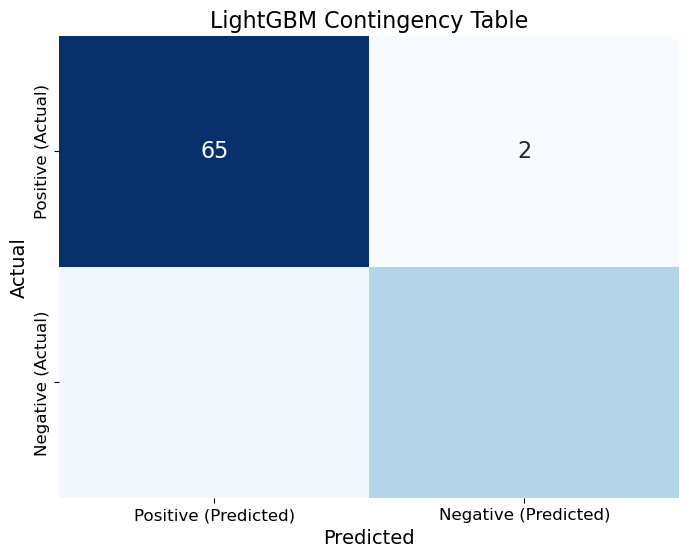


Features used in the model and their importance:
                                              Feature  Importance
0                                                 Age         164
5                                                 USG         118
1                                         Weight (kg)         101
4                          Duration of therapy (days)          93
7                                             Protein          90
11                                             Volume          80
2                                Number of vet visits          79
30                              Bacteria quantity_3.0          74
6                                                  PH          73
10                                        Hemoprotein          72
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...          58
14                                   RBC (simplified)          50
12                                        Lipid Layer          49
13                        

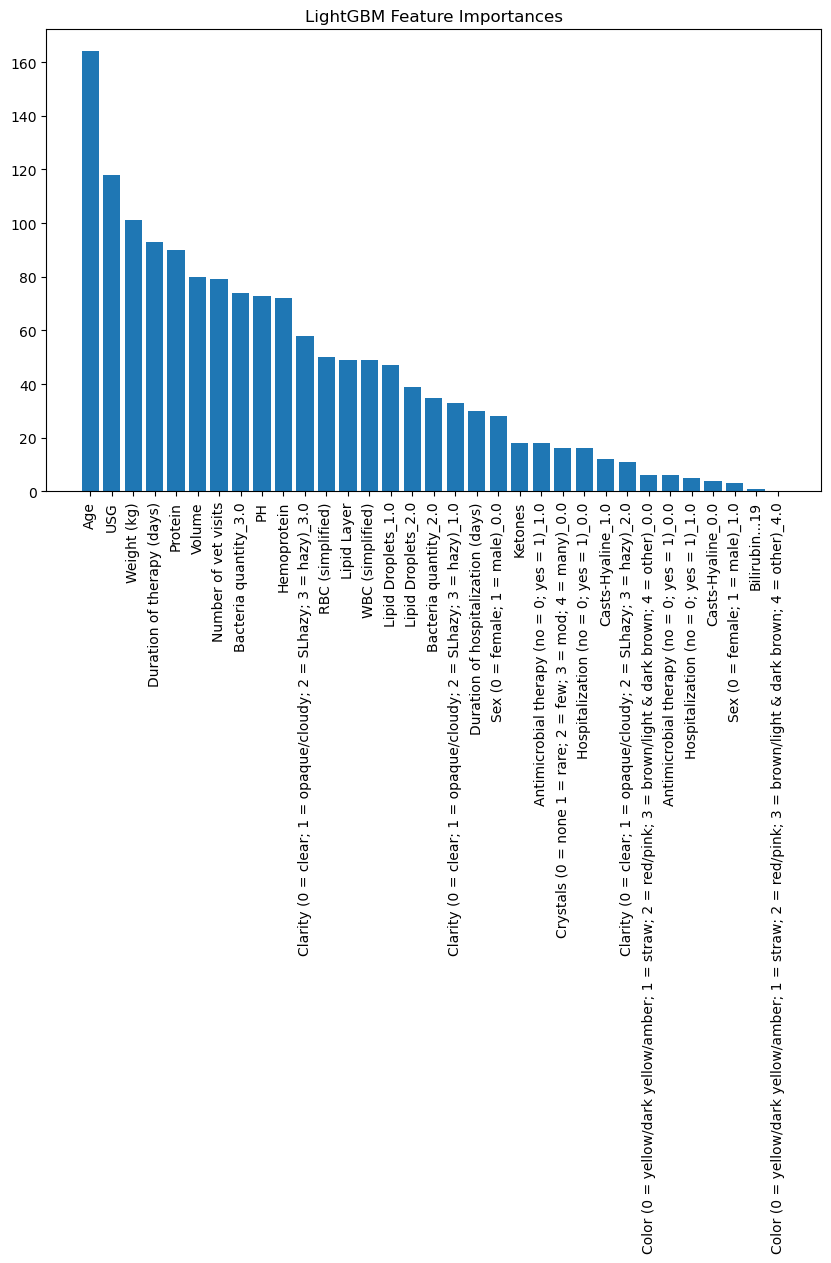

Training XGBoost...

XGBoost Performance:
Sensitivity: 0.9403, Specificity: 0.7200
Accuracy: 0.8804 (95% CI: [0.8141, 0.9467])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    63                     4
Negative (Actual)                     7                    18


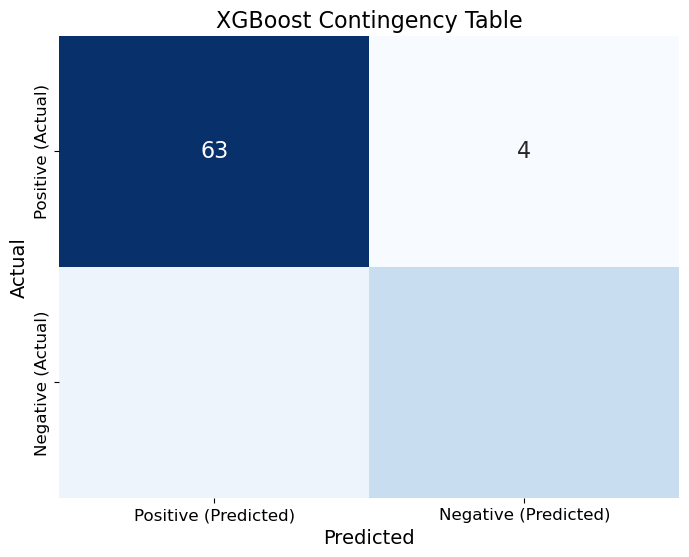


Features used in the model and their importance:
                                              Feature  Importance
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    0.179711
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    0.119142
8                                             Ketones    0.077566
31                                 Lipid Droplets_1.0    0.062987
4                          Duration of therapy (days)    0.057859
13                                   WBC (simplified)    0.033857
17              Hospitalization (no = 0; yes = 1)_0.0    0.033433
28                                  Casts-Hyaline_1.0    0.032712
24  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...    0.028799
21  Color (0 = yellow/dark yellow/amber; 1 = straw...    0.028707
26  Crystals (0 = none 1 = rare; 2 = few; 3 = mod;...    0.027352
14                                   RBC (simplified)    0.025370
29                              Bacteria quantity_2.0    0.024928
0                         

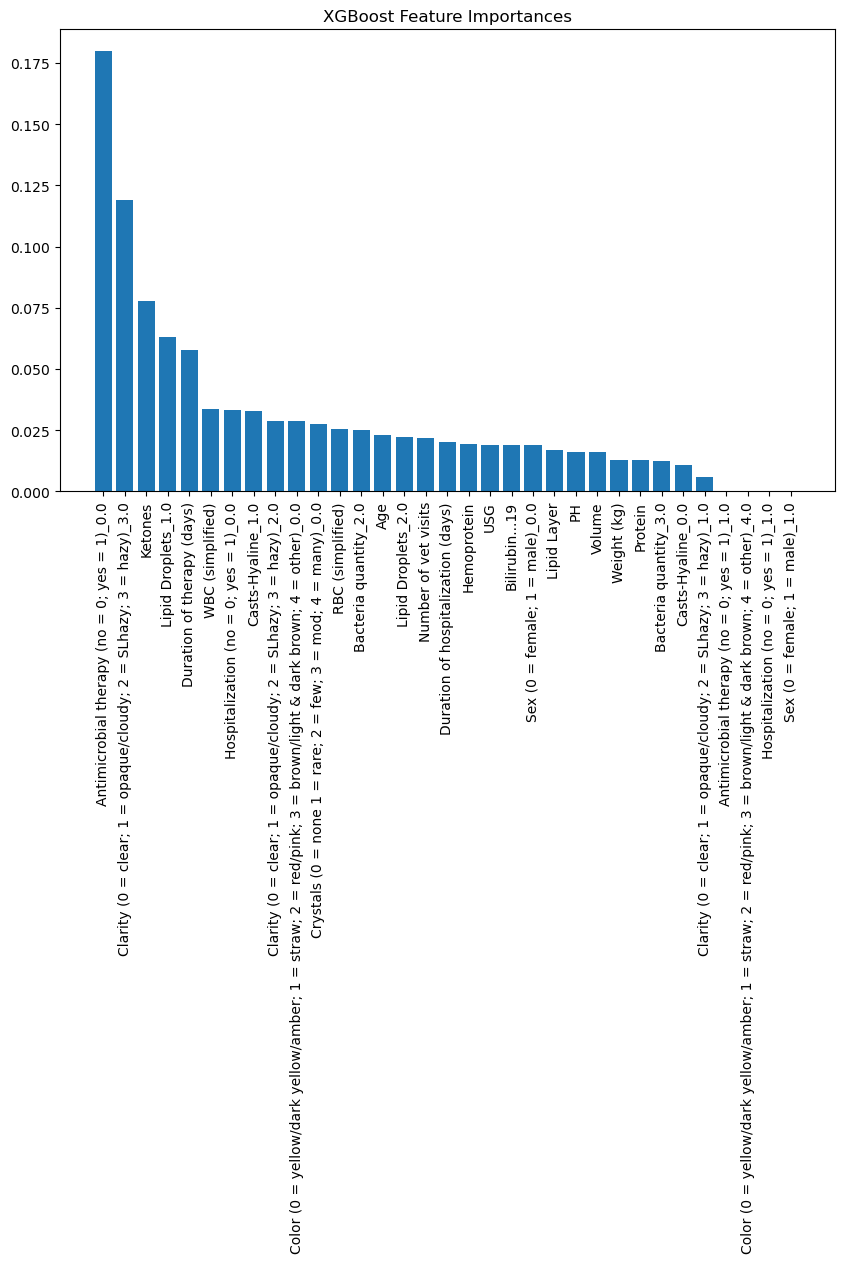

Training CatBoost...

CatBoost Performance:
Sensitivity: 0.9254, Specificity: 0.7600
Accuracy: 0.8804 (95% CI: [0.8141, 0.9467])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    62                     5
Negative (Actual)                     6                    19


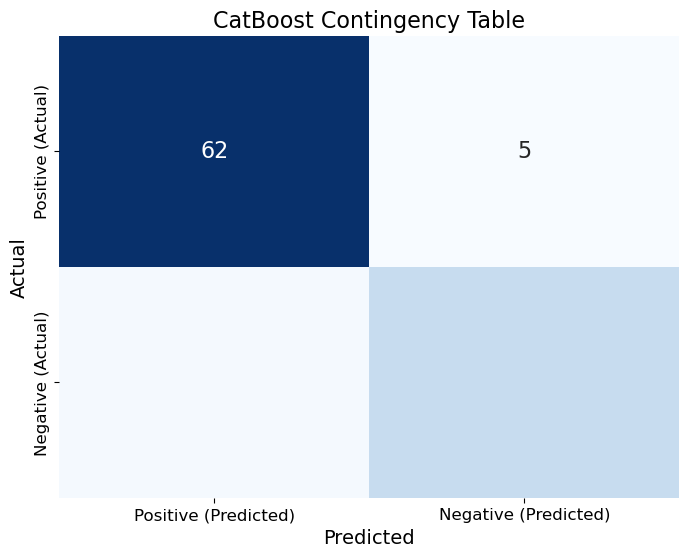


Features used in the model and their importance:
                                              Feature  Importance
25  Clarity (0 = clear; 1 = opaque/cloudy; 2 = SLh...   11.573338
20        Antimicrobial therapy (no = 0; yes = 1)_1.0    5.976487
19        Antimicrobial therapy (no = 0; yes = 1)_0.0    5.369800
4                          Duration of therapy (days)    4.825006
5                                                 USG    4.724349
12                                        Lipid Layer    4.319494
6                                                  PH    4.299585
30                              Bacteria quantity_3.0    4.155410
0                                                 Age    3.934712
10                                        Hemoprotein    3.773322
13                                   WBC (simplified)    3.681172
2                                Number of vet visits    3.632000
11                                             Volume    3.466896
32                        

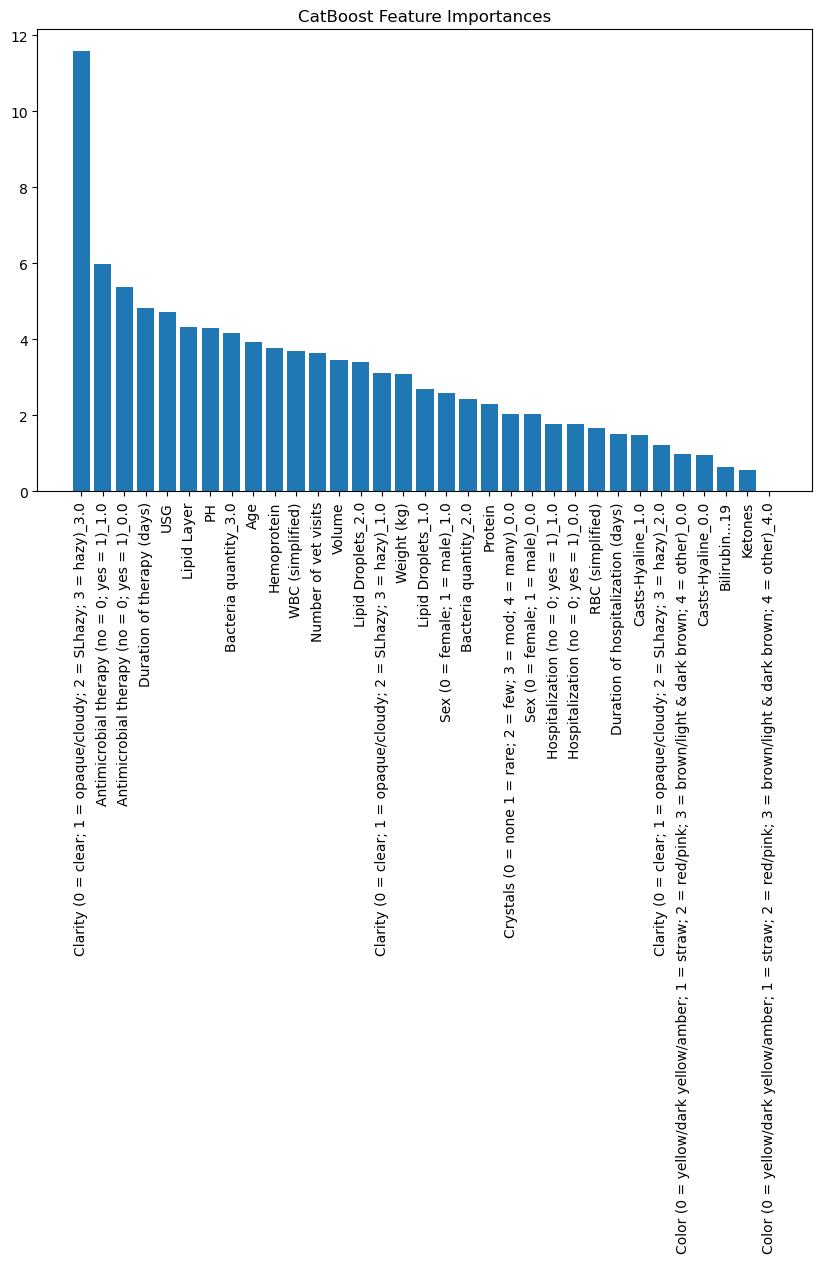

Training LogisticRegression...

LogisticRegression Performance:
Sensitivity: 0.8806, Specificity: 0.6800
Accuracy: 0.8261 (95% CI: [0.7486, 0.9035])

Contingency Table:
                   Positive (Predicted)  Negative (Predicted)
Positive (Actual)                    59                     8
Negative (Actual)                     8                    17


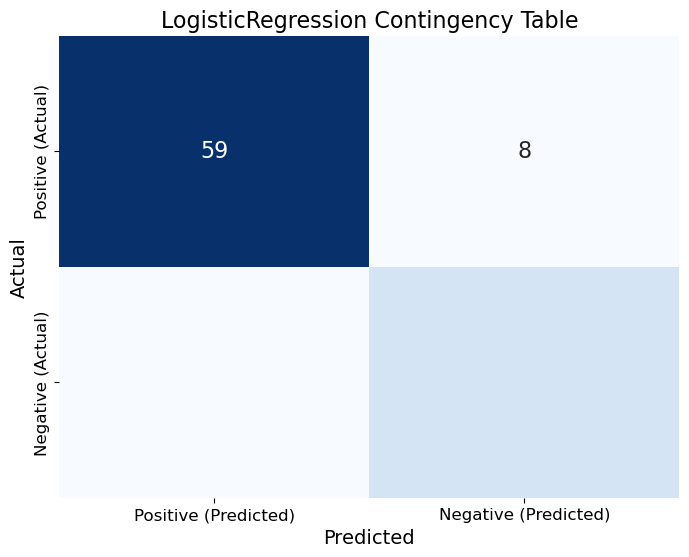

In [4]:
import seaborn as sns  # For heatmap visualization

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)  # Ensure the model is trained
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_test, y_pred)
    n = len(y_test)
    p = accuracy
    z = 1.96  # 95% confidence interval
    ci_lower = max(0, p - z * np.sqrt((p * (1 - p)) / n))
    ci_upper = min(1, p + z * np.sqrt((p * (1 - p)) / n))
    
    print(f"\n{name} Performance:")
    print(f"Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
    print(f"Accuracy: {accuracy:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
    
    # Contingency table (2x2 table)
    print("\nContingency Table:")
    contingency_table = pd.DataFrame(
        [[tp, fn], [fp, tn]],
        columns=["Positive (Predicted)", "Negative (Predicted)"],
        index=["Positive (Actual)", "Negative (Actual)"]
    )
    print(contingency_table)
    
    # Visualize the contingency table
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
    plt.title(f"{name} Contingency Table", fontsize=16)
    plt.xlabel("Predicted", fontsize=14)
    plt.ylabel("Actual", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Features used in the model
    if hasattr(model, "feature_importances_"):
        print("\nFeatures used in the model and their importance:")
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": static_feature_names,
            "Importance": importances
        }).sort_values(by="Importance", ascending=False)
        print(feature_importance_df)
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importances")
        plt.bar(range(len(importances)), feature_importance_df["Importance"], align="center")
        plt.xticks(range(len(importances)), feature_importance_df["Feature"], rotation=90)
        plt.tight_layout()
        plt.show()
